In [1]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.3

pos = graphviz_layout(gnx, root=0)

infection_times, source, obs_nodes, tree = gen_nontrivial_cascade(g, p, q, model='ic', return_tree=True)

In [3]:
from collections import Counter
from utils import build_minimum_tree

def nikolaj_bfs(g, root, infection_times, source, terminals,
                debug=False,
                verbose=True):    
    terminals = set(terminals)
    visited = {root}
    edges = []

    processed_by_time = Counter()
    for v in terminals:
        processed_by_time[infection_times[v]] += 1

    terminals_sorted = list(sorted(terminals,
                               key=lambda t: (infection_times[t], (t not in visited))))

    all_times_sorted = list(sorted(map(infection_times.__getitem__, terminals)))
    tmin = infection_times[root]
    tmin_idx = 0
    processed_by_time[tmin] -= 1

    # update tmin
    if processed_by_time[tmin] == 0:
        tmin_idx += 1
        tmin = all_times_sorted[tmin_idx]

    queue = [root] 
    delayed = set()
    while len(queue) > 0:        
        u = queue.pop(0)
        for v in g.vertex(u).all_neighbours():
            v = int(v)
            if v not in visited:
                edges.append((u, v))
                visited.add(v)
                if v in terminals:
                    delayed.add(v)
                    processed_by_time[infection_times[v]] -= 1
                else:
                    queue.append(v)
        # update tmin
        while processed_by_time[tmin] == 0 and tmin_idx < len(all_times_sorted)-1:
            tmin_idx += 1
            tmin = all_times_sorted[tmin_idx]

        # re-enqueue delayed terminal nodes
        for v in terminals_sorted:
            if v in delayed:
                if infection_times[v] > tmin:
                    break
                else:
                    delayed.remove(v)
                    queue.append(v)
    
    return build_minimum_tree(g, root, terminals, edges)
                        

In [6]:
from tqdm import tqdm
from feasibility import is_feasible
from utils import earliest_obs_node

for i in tqdm(range(100)):
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True)
    root = earliest_obs_node(obs_nodes, infection_times)

    tree = nikolaj_bfs(
        g, root, infection_times, source, obs_nodes,
        debug=False,
        verbose=False
    )
    # assert is_order_respected(tree, root, obs_nodes, infection_times)
    assert is_feasible(tree, root, obs_nodes, infection_times)

100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


<IPython.core.display.Javascript object>


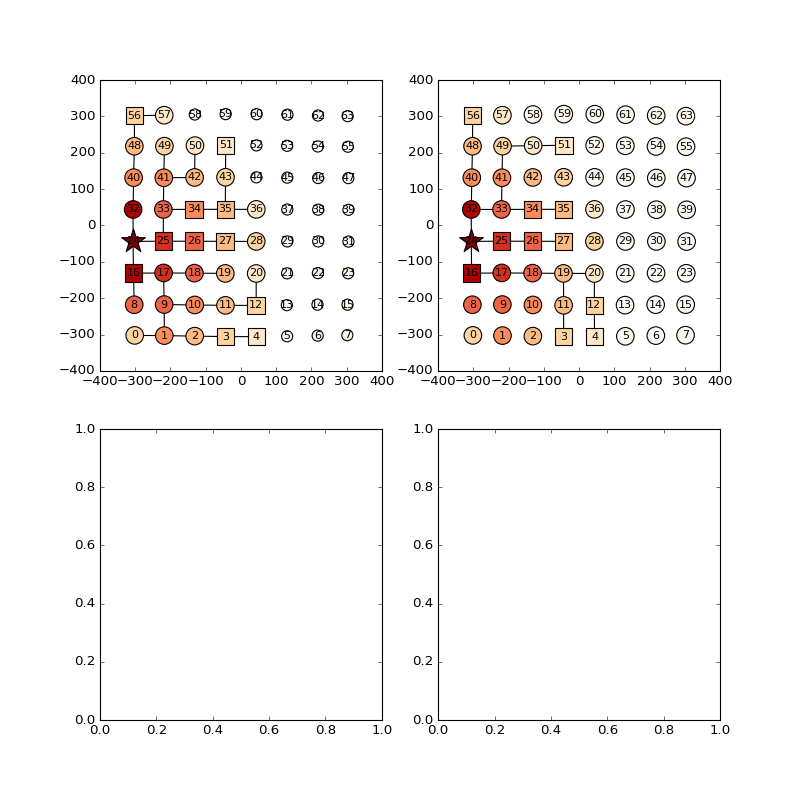

In [7]:
from plot_utils import plot_snapshot
from utils import extract_edges
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
             ax=ax[0, 1], arrows=True,
             edges=extract_edges(tree))